In [5]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics
from asap.annotation import ASAPNMF
import asapc
import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
from sklearn.preprocessing import StandardScaler
# import logging


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id


dl = DataSet(sample_in,sample_out)
n_per_sample=1000
sample_list = dl.get_samplenames()
dl.initialize_data(sample_list,n_per_sample)

print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/osteosarcoma/osteosarcoma
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/osteosarcoma/osteosarcoma


In [6]:
model = np.load(sample_out+'_dcnmf.npz')

In [7]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.genes
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

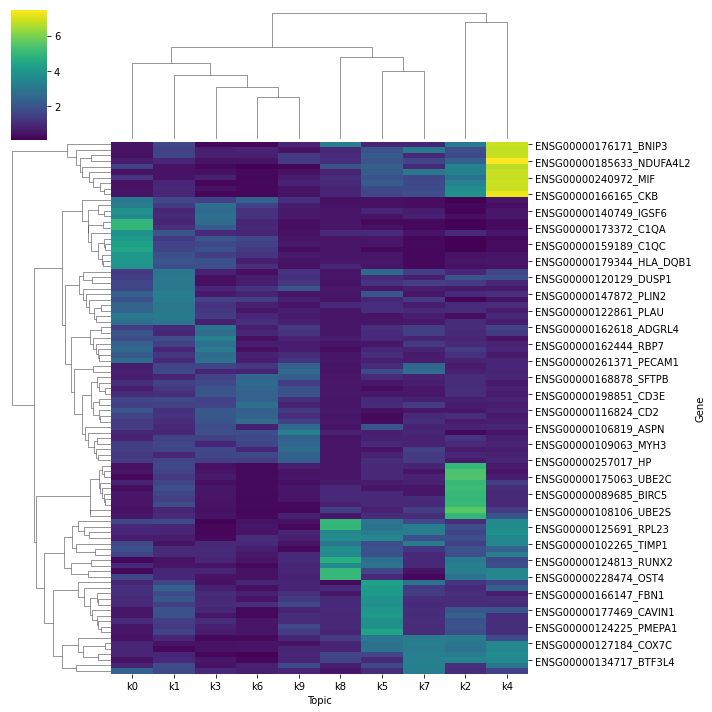

In [8]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [9]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACCTGAGACTCGGA-1_BC10,7,4.284438,11.257629
1,AAACCTGAGACTTGAA-1_BC10,7,5.170465,6.890112
2,AAACCTGAGCTCCTTC-1_BC10,1,4.932990,7.010604
3,AAACCTGAGGAACTGC-1_BC10,7,5.119199,9.369511
4,AAACCTGAGGAGTCTG-1_BC10,1,5.897868,1.795801
...,...,...,...,...
10995,AAGTCTGGTTTGTTGG-1_BC6,1,5.191633,0.572326
10996,AAGTCTGTCAAGGTAA-1_BC6,7,1.604878,8.863856
10997,AAGTCTGTCACCGTAA-1_BC6,3,13.512994,-1.792941
10998,AAGTCTGTCACTGGGC-1_BC6,1,5.172635,0.915993


Text(0, 0.5, 'UMAP2')

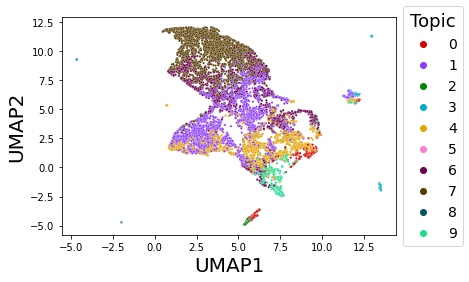

In [10]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

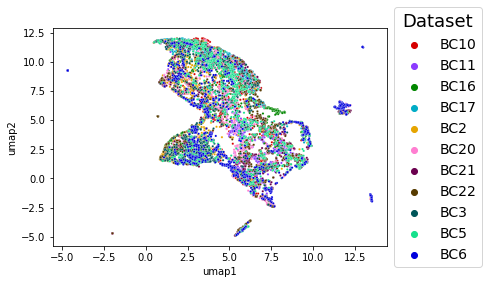

In [11]:
df_umap['batch'] = [x.split('_')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='Dataset',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))